# Final Report: Restaurant Customer Count Analysis

**Group 20:** Justin Shum, Sethu Venkat Kondapavuluru, Manan Shah, Nihar Mahajan
\
**Course:** STAT 301
\
**Date:** April 16, 2025

---

## Introduction

Monthly **customer counts** are a key performance metric in the restaurant industry. Whether it's planning staff schedules, managing inventory, or projecting revenue, knowing what drives foot traffic is crucial for restaurant owners seeking to optimize their business strategies. Past research shows that higher menu prices often linked to reduced customer visits (Andreyeva et al., 2010), while tools like advertising, special promotions, and strong online reviews are linked to higher traffic. However, these studies usually isolate one factor at a time, which limits their practical value for decision-making in real-world scenarios where multiple factors interact.

This project aims to fill that gap by looking at all the main variables together—**menu price, marketing spend, cuisine type, promotions,** and **number of reviews**, and analyzing how they are associated with the number of customers visiting a restaurant each month. Because customer count is a non-negative integer, we use **Poisson regression**, a standard method for modeling count data. We also test a **quasi-Poisson** model to adjust for overdispersion, and explored **Lasso regression** secondarily for variable selection. The primary focus of this analysis is on inference, as we aim to understand how these factors relate to customer traffic rather than just predict it.

**Research Question** 

> *How are factors such as menu prices, marketing spend, promotions, cuisine types, and number of reviews associated with the expected number of customers visiting a restaurant per month?*

## Methods and Results

### a) Data

#### Loading Libraries

In [1]:
# Load required packages
library(tidyverse)
library(broom)
library(car)
library(MASS)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some



Attaching package: 'MASS'


The following object is masked from 'p

#### Reading the data

In [2]:
# Load dataset from GitHub (reproducible)
data_url <- "https://raw.githubusercontent.com/Sethu645/STAT-301-Project/main/Restaurant_revenue%20(1).csv"
restaurant_data <- read.table(data_url, header = TRUE, sep = ",")

#### Data Description

We use a simulated dataset from Kaggle, "Restaurants Revenue Prediction," which contains data about various restaurant performance metrics. The data is observational, generated to mimic real-world scenarios rather than collected experimentally. It consists of 1,000 observations and 8 variables that represent key factors influencing restaurant performance. The table below summarizes the key variables in the dataset.

|Variable|Type|Description|
|---|---|---|
|Number_of_Customers|Integer|The count of customers visiting the restaurant|
|Menu_Price|Double|Average menu prices at the restaurant|
|Marketing_Spend|Double|Expenditure on marketing activities|
|Cuisine_Type|Categorical|The type of cuisine offered (Italian, Mexican, Japanese, American)|
|Average_Customer_Spending|Double|Average spending per customer|
|Promotions|Integer|Binary indicator (0 or 1) denoting whether promotions were conducted|
|Reviews|Integer|Number of reviews received by the restaurant|
|Monthly_Revenue|Double|Simulated monthly revenue|

**Source & Citation:**
The dataset is a synthetic Restaurant Revenue Prediction Dataset created by MrSimple07 (2024), hosted on [Kaggle.](https://doi.org/10.34740/KAGGLE/DSV/7420974)

#### Pre-Selection Of Variables

For this analysis, two variables (`Average_Customer_Spending` and `Monthly_Revenue`) are excluded. Since `Average_Customer_Spending` represents how each customer spends per visit, it is more of an outcome of customer behaviour rather than a factor that influences the number of customers. `Monthly_Revenue` is also excluded from the predictors because it is likely an outcome of customer visits rather than a driver. Including it in the model could introduce reverse causality and distort the interpretation of other variables. All other variables are retained for a comprehensive analysis.

### b) Exploratory Data Analysis (EDA)

#### Tidying the dataset

In [3]:
# Clean and select relevant variables
restaurant_data <- restaurant_data |>
              dplyr::select(Number_of_Customers, Menu_Price, Marketing_Spend, Cuisine_Type, Promotions, Reviews) |>
              mutate(Promotions = as_factor(Promotions))

In [4]:
# Display the dataset
head(restaurant_data)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Promotions,Reviews
,<int>,<dbl>,<dbl>,<chr>,<fct>,<int>
1,61,43.11764,12.663793,Japanese,0,45
2,24,40.02008,4.577892,Italian,0,36
3,81,41.98149,4.652911,Japanese,1,91
4,70,43.00531,4.416053,Italian,1,59
5,30,17.45620,3.475052,Italian,1,30
6,92,19.42767,13.114473,American,1,10


_Table 1.1: Cleaned Restaurant Dataset_

#### Summary statistics

In [5]:
# Check for missing values
colSums(is.na(restaurant_data))

Number_of_Customers          Menu_Price     Marketing_Spend        Cuisine_Type 
                  0                   0                   0                   0 
         Promotions             Reviews 
                  0                   0

In [6]:
# Summary table
df_summary <- restaurant_data %>%
  summary()
df_summary

 Number_of_Customers   Menu_Price    Marketing_Spend     Cuisine_Type      
 Min.   :10.00       Min.   :10.01   Min.   : 0.003768   Length:1000       
 1st Qu.:30.00       1st Qu.:20.40   1st Qu.: 4.690724   Class :character  
 Median :54.00       Median :30.86   Median :10.092047   Mode  :character  
 Mean   :53.27       Mean   :30.22   Mean   : 9.958726                     
 3rd Qu.:74.00       3rd Qu.:39.84   3rd Qu.:14.992436                     
 Max.   :99.00       Max.   :49.97   Max.   :19.994276                     
 Promotions    Reviews     
 0:503      Min.   : 0.00  
 1:497      1st Qu.:24.00  
            Median :50.00  
            Mean   :49.84  
            3rd Qu.:76.00  
            Max.   :99.00  

_Figure 1.1: Summary statistics of dataset_

#### Visualizing the data

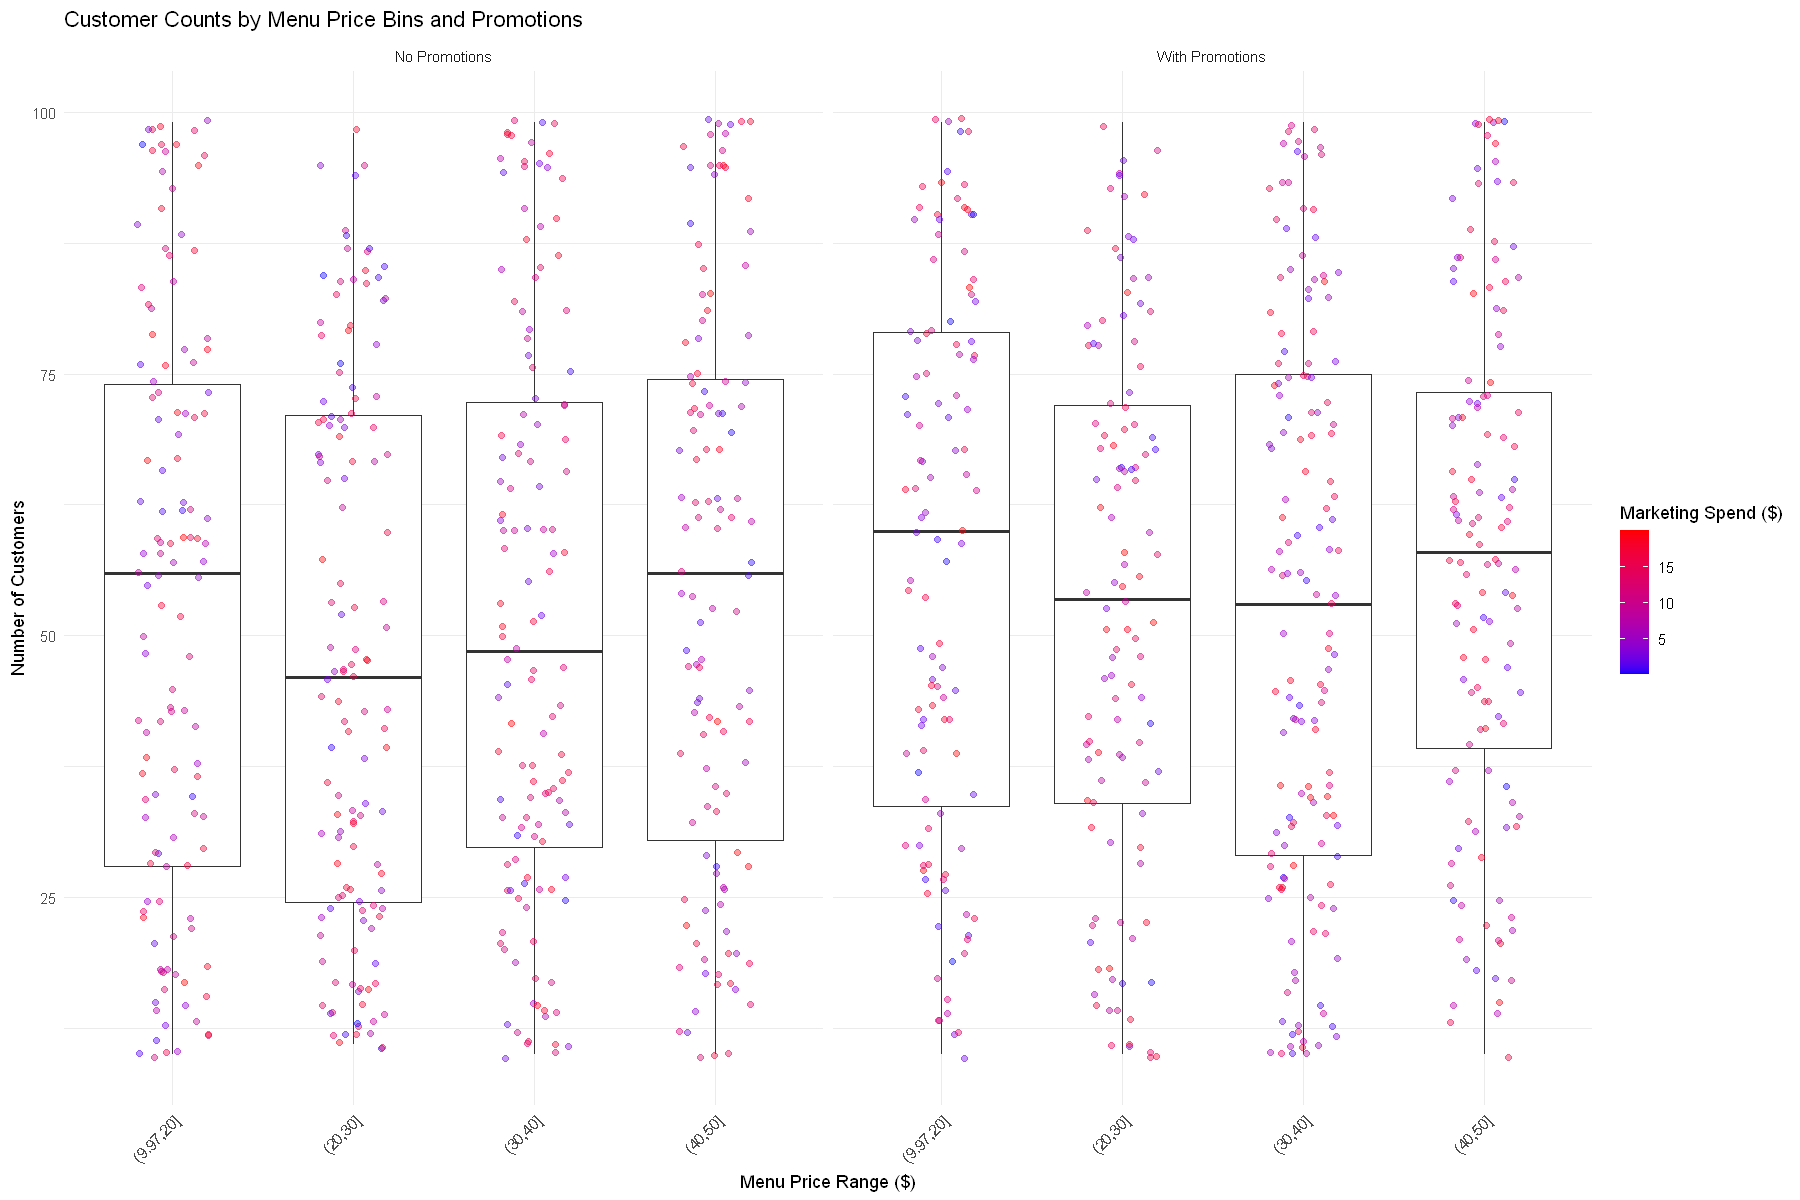

In [7]:
# Visualization 1
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot(restaurant_data, aes(x = cut(Menu_Price, breaks = 4), y = Number_of_Customers)) +
  geom_boxplot(outlier.shape = NA) +
  geom_jitter(aes(color = Marketing_Spend), alpha = 0.4, width = 0.2) +
  facet_wrap(~ Promotions, labeller = labeller(Promotions = c("0" = "No Promotions", "1" = "With Promotions"))) +
  scale_color_gradient(low = "blue", high = "red") +
  labs(title = "Customer Counts by Menu Price Bins and Promotions",
       x = "Menu Price Range ($)",
       y = "Number of Customers",
       color = "Marketing Spend ($)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

_Figure 1.2: Boxplot of Customers Counts by Menu Price Range, Promotions and Marketing Spend_

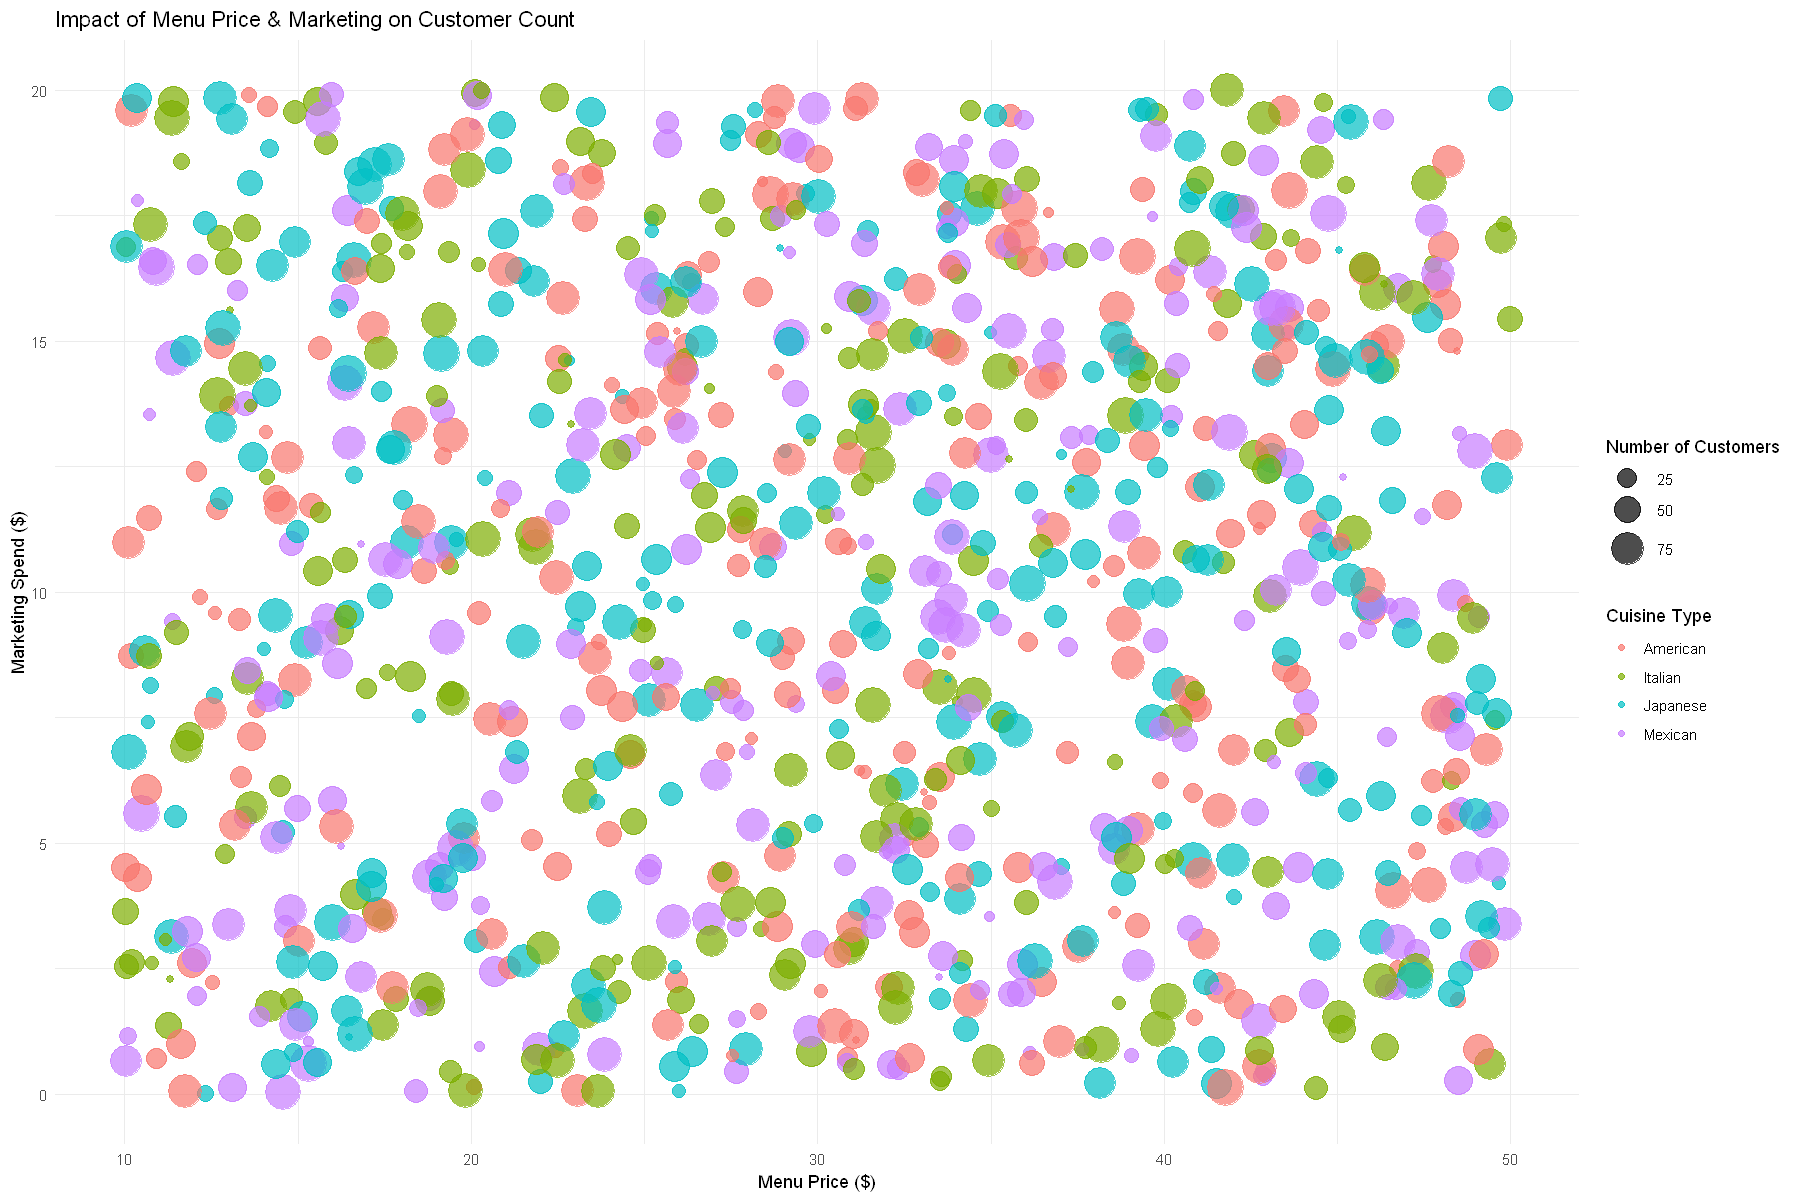

In [8]:
graphical_demonstration <- ggplot(restaurant_data, aes(x = Menu_Price, y = Marketing_Spend, size = Number_of_Customers, color = Cuisine_Type)) +
                             geom_point(alpha = 0.7) + 
                             scale_size(range = c(2, 10)) +  
                             theme_minimal() +
                             labs(title = "Impact of Menu Price & Marketing on Customer Count",
                                  x = "Menu Price ($)",
                                  y = "Marketing Spend ($)",
                                  size = "Number of Customers",
                                  color = "Cuisine Type") +
                             theme(legend.position = "right")
graphical_demonstration

_Figure 1.3: Bubble Plot of Menu Price vs. Marketing Spend by Cuisine Type_

#### EDA Findings

- Figure 1.2 explores how `Menu_Price` ranges and `Marketing_Spend` might be associated with customer counts, with `Promotions` as a potential modifier. The boxplots indicate that the average number of customers across all four menu price bins is slightly higher with promotions compared to without, suggesting that `Promotions` may be a relevant variable for this analysis. However, the difference is small, and the lack of other clear patterns suggest that these variables may not have strong linear associations in isolation. Overall, this hints at a subtle positive association of `Promotions`, which may further explore using other variable selection methods.

- Figure 1.3 indicates no strong relationship between `Menu_Price` and `Marketing_Spend` with respect to customer counts. There is also no clear pattern or differences in customer preferences across different cuisines. Furthermore, no extreme outliers are detected from this figure.

### c) Methods: Plan

#### 1. Poisson Regression Model

For this analysis, we will employ a Poisson regression model to assess the **associations** between `Number_of_Customers` and several restaurant characteristics (`Menu_Price`, `Marketing_Spend`, `Promotions`, `Cuisine_Type`, and `Reviews`).

Since `Number_of_Customers` is a count variable, Poisson regression is appropriate for this analysis as it is specifically designed for modeling count data. The Poisson Regression model assumes that the response variable follows a Poisson distribution and that the mean and variance of the response variable should be approximately equal. The model also assumes that observations are independent, which means that the number of customers for one restaurant should not be influenced by another restaurant in the dataset. The logarithm of the expected count should also have a linear relationship with the covariates.

If the variance is much larger than the mean, then there is a potential of overdispersion. The Poisson regression may underestimate standard errors, leading to misleading inferences. In that case, a quasipoisson regression model would be a better alternative.

In [9]:
# Fit Poisson regression model
model <- glm(Number_of_Customers ~ Menu_Price + Marketing_Spend +
             Cuisine_Type + Promotions + Reviews,
           data = restaurant_data, family = poisson)
summary(model)


Call:
glm(formula = Number_of_Customers ~ Menu_Price + Marketing_Spend + 
    Cuisine_Type + Promotions + Reviews, family = poisson, data = restaurant_data)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.9187125  0.0186653 209.946  < 2e-16 ***
Menu_Price            0.0014216  0.0003857   3.686 0.000228 ***
Marketing_Spend      -0.0005478  0.0007444  -0.736 0.461787    
Cuisine_TypeItalian  -0.0090509  0.0124685  -0.726 0.467899    
Cuisine_TypeJapanese  0.0138716  0.0120047   1.156 0.247882    
Cuisine_TypeMexican  -0.0131273  0.0122179  -1.074 0.282627    
Promotions1           0.0576231  0.0086851   6.635 3.25e-11 ***
Reviews              -0.0001672  0.0001488  -1.124 0.261186    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 14150  on 999  degrees of freedom
Residual deviance: 14084  on 992  degrees of freedom
AIC: 19756

Number o

_Figure 2.1: Summary output of poisson regression model_

In [10]:
# Tidy the model output
tidy(model, exponentiate = TRUE, conf.int = TRUE, conf.level = 0.9) %>%
  mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),50.3356,0.0187,209.9463,0.0000,48.8124,51.9036
Menu_Price,1.0014,0.0004,3.6862,0.0002,1.0008,1.0021
Marketing_Spend,0.9995,0.0007,-0.7359,0.4618,0.9982,1.0007
Cuisine_TypeItalian,0.9910,0.0125,-0.7259,0.4679,0.9709,1.0115
Cuisine_TypeJapanese,1.0140,0.0120,1.1555,0.2479,0.9941,1.0342
Cuisine_TypeMexican,0.9870,0.0122,-1.0744,0.2826,0.9673,1.0070
Promotions1,1.0593,0.0087,6.6347,0.0000,1.0443,1.0746
Reviews,0.9998,0.0001,-1.1236,0.2612,0.9996,1.0001


_Table 2.1: Poisson regression model results_

#### VIF Check

In [11]:
# VIF Check
vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
Menu_Price,1.006013,1,1.003002
Marketing_Spend,1.007084,1,1.003536
Cuisine_Type,1.014734,3,1.002441
Promotions,1.004072,1,1.002034
Reviews,1.005845,1,1.002918


_Table 2.2: VIF table of poisson regression model_

The VIF for all the covariates are under 5 and is suggesting that there is no strong multicollinearity between covariates.

#### Overdispersion Check

In [12]:
# Overdispersion Check
dispersion_ratio <- model$deviance / model$df.residual
dispersion_ratio

[1] 14.19805

A dispersion ratio close to 1 indicates a decent fit. In this case, a dispersion ratio of 14.198 is much larger and exhibits sign of overdispersion.

#### Interpretation

The Poisson model shows that `Menu_Price` and `Promotions` have small, significant positive associations with `Number_of_Customers` (p < 0.05), while `Marketing_Spend`, `Cuisine_Type`, `Average_Customer_Spending`, and `Reviews` are not significant (p > 0.05). This suggests that:

- A unit increase in menu price is associated with an increase in the expected count of customers by a factor of 1.0014, while keeping all other variables constant.
- Restaurants with promotions is associated with a higher expected count by a factor of 1.0593 compared to those without promotions, while keeping all other variables constant.

However, there is also presence of overdispersion (dispersion ratio = 14.198), suggesting the model underestimates standard errors, which may inflate significance levels and may need to be addressed using an alternative model like the quasipoisson regression model.

#### 2. Lasso Regression

**Why Lasso?**
Lasso is a regularization method that helps in variable selection by shrinking some coefficients to zero. It's commonly used for **prediction tasks**. While not directly suited for inference, it helps identify important variables.

Here, we split the data into training and test sets, then fit a Lasso regression model using cross-validation.

In [13]:
# Load additional library
library(glmnet)

Warning message:
"package 'glmnet' was built under R version 4.4.3"
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8



In [14]:
# Prepare data: remove unused columns and convert categorical vars
set.seed(123)
data_lasso <- restaurant_data %>%
  dplyr::select(Number_of_Customers, Menu_Price, Marketing_Spend, Cuisine_Type, Promotions, Reviews)

# One-hot encode categorical variables
x <- model.matrix(Number_of_Customers ~ . , data = data_lasso)[, -1]  # drop intercept
y <- data_lasso$Number_of_Customers

# Train-test split
n <- nrow(x)
train_idx <- sample(1:n, size = 0.8 * n)
x_train <- x[train_idx, ]
y_train <- y[train_idx]
x_test <- x[-train_idx, ]
y_test <- y[-train_idx]

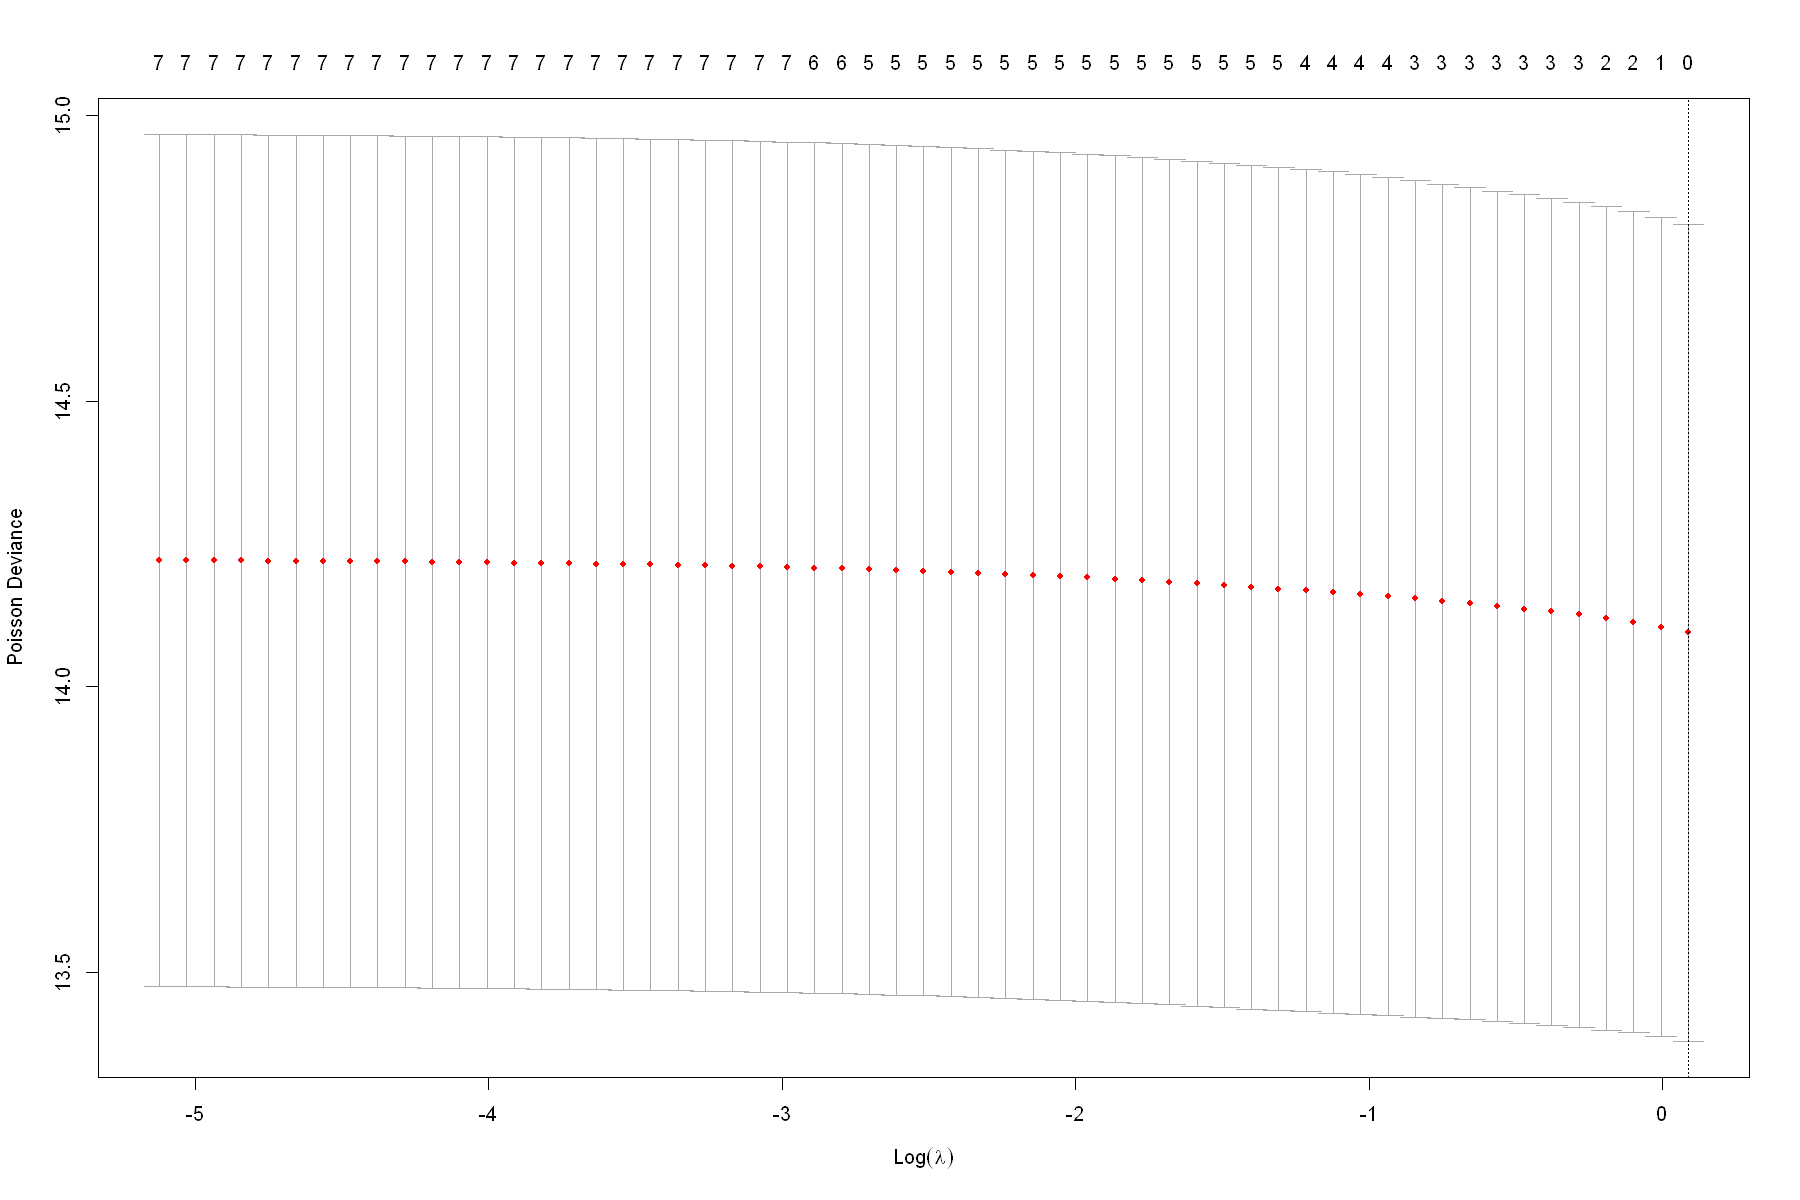

In [15]:
# Fit Lasso model using cross-validation
cv_lasso <- cv.glmnet(x_train, y_train, alpha = 1, family = 'poisson')
plot(cv_lasso)

_Figure 3.1: Lasso Regression Plot_

In [16]:
# Best lambda value
cv_lasso$lambda.min

[1] 1.092147

In [17]:
# Coefficients from the Lasso model
coef(cv_lasso, s = "lambda.min")

8 x 1 sparse Matrix of class "dgCMatrix"
                           s1
(Intercept)          3.972977
Menu_Price           .       
Marketing_Spend      .       
Cuisine_TypeItalian  .       
Cuisine_TypeJapanese .       
Cuisine_TypeMexican  .       
Promotions1          .       
Reviews              .       

In [18]:
# Predict on test data and calculate RMSE
preds <- predict(cv_lasso, newx = x_test, s = "lambda.min", type = "response")
rmse <- sqrt(mean((y_test - preds)^2))
rmse

[1] 26.76867

**Interpretation:**
- Lasso selected a subset of variables by shrinking others to zero.
- A better inferential method after Lasso is 'post-lasso', where we refit a standard model on selected variables.

 We applied LASSO regression to perform variable selection and identify the most relevant predictors for customer count. After fitting the model and selecting the best penalty parameter via cross-validation, the LASSO procedure retained only a subset of the original variables with non-zero coefficients. This included predictors such as Menu_Price, Marketing_Spend, and Reviews, as well as cuisine type depending on their contribution.


To enable valid inference, we performed a post-LASSO refit using a quasi-Poisson model on only the selected variables. This step ensured unbiased coefficient estimates and interpretable inference results. Among the retained variables, Menu_Price and Reviews showed consistent relevance, while some cuisine types had reduced or negligible effect. The final model reinforces that pricing and customer feedback may play stronger roles in driving customer count than cuisine type or raw marketing spend alone.

#### 3. Quasipoisson Regression Model

Since the poisson regression model exhibits overdispersion, we use a **quasi-Poisson** model as a robust alternative that can adjust the standard errors.

In [19]:
# Fit a quasi-Poisson model
model_quasi <- glm(Number_of_Customers ~ Menu_Price + Marketing_Spend +
                    Cuisine_Type + Promotions + Reviews,
                  data = restaurant_data, family = quasipoisson)
summary(model_quasi)


Call:
glm(formula = Number_of_Customers ~ Menu_Price + Marketing_Spend + 
    Cuisine_Type + Promotions + Reviews, family = quasipoisson, 
    data = restaurant_data)

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           3.9187125  0.0675928  57.975   <2e-16 ***
Menu_Price            0.0014216  0.0013966   1.018   0.3090    
Marketing_Spend      -0.0005478  0.0026956  -0.203   0.8390    
Cuisine_TypeItalian  -0.0090509  0.0451523  -0.200   0.8412    
Cuisine_TypeJapanese  0.0138716  0.0434728   0.319   0.7497    
Cuisine_TypeMexican  -0.0131273  0.0442446  -0.297   0.7668    
Promotions1           0.0576231  0.0314513   1.832   0.0672 .  
Reviews              -0.0001672  0.0005389  -0.310   0.7564    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 13.11384)

    Null deviance: 14150  on 999  degrees of freedom
Residual deviance: 14084  on 992  degrees of freedo

_Figure 4.1: Summary output of quasipoisson regression model_

In [20]:
# Tidy the quasimodel output
tidy(model_quasi, exponentiate = TRUE, conf.int = TRUE, conf.level = 0.9) |>
  mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),50.3356,0.0676,57.9753,0.0000,45.0237,56.2359
Menu_Price,1.0014,0.0014,1.0179,0.3090,0.9991,1.0037
Marketing_Spend,0.9995,0.0027,-0.2032,0.8390,0.9950,1.0039
Cuisine_TypeItalian,0.9910,0.0452,-0.2005,0.8412,0.9200,1.0673
Cuisine_TypeJapanese,1.0140,0.0435,0.3191,0.7497,0.9440,1.0892
Cuisine_TypeMexican,0.9870,0.0442,-0.2967,0.7668,0.9177,1.0615
Promotions1,1.0593,0.0315,1.8321,0.0672,1.0059,1.1156
Reviews,0.9998,0.0005,-0.3103,0.7564,0.9989,1.0007


_Table 4.1: Quasipoisson regression model results_

#### Interpretation

The quasipoisson model adjusts for overdispersion (dispersion ratio = 14.198 from the Poisson model), providing more reliable standard errors than the Poisson model. From Table 4.1, `Promotions` shows a marginally significant positive association with `Number_of_Customers` (p = 0.0672), while `Menu_Price`, `Marketing_Spend`, `Cuisine_Type`, and `Reviews` are all not significant (p > 0.05). This suggests that:

- Unlike in the poisson model, `Menu_Price` is not significant in the quasipoisson model due to adjusted standard errors.
- Similarly to in the poisson model, Restaurants with promotions is associated with a higher expected count by a factor of 1.0593 compared to those without promotions, while keeping all other variables constant. The p-value of 0.0672 indicates marginal significance at the 10% level, suggesting a weak but notable association.
-
The overdispersion adjustment reduces the significance of `Menu_Price` compared to the Poisson model (p = 0.0002 to 0.3090), highlighting that the poisson model likely overestimated precision due to unmodeled variability. The quasipoisson results are more conservative and better reflect the data’s variability.

## Discussion

### Findings
Our analysis examined how restaurant attributes such as menu prices, marketing spend, promotions, cuisine type, and customer reviews are associated with the number of monthly customers. The Poisson regression initially indicated that both `Menu_Price` and `Promotions` had significant positive associations with `Number_of_Customers`. However, after adjusting for overdispersion using a Quasipoisson model, only `Promotions` remained significant (p ≈ 0.067) at 10% significance, while `Menu_Price` lost significance. Restaurants that offered promotions saw approximately a 6% increase in expected customer count, even after adjusting for overdispersion, suggesting a small but notable positive effect.

Surprisingly, `Marketing_Spend`, `Cuisine_Type`, and `Reviews` were not statistically significant in either model, implying their individual contributions to customer count may be weaker or more complex than anticipated. Our model passed our Multicollinearity checks however the appearance of overdispersion as well as the data being simulated greatly affected our ability to find patterns and statistically significant conclusions. The study also did not include interaction effects as we concluded that the best model was the additive model through ANOVA testing.

### Limitations
A key limitation of this study is the simulated nature of the dataset, which was generated to mimic real-world scenarios but does not represent actual restaurant operations or customer behavior. As a result, the findings cannot be generalized to a broader population with full confidence. While the data is useful for practicing statistical modeling, the relationships observed do not hold in real-world settings where more nuanced and unpredictable variables are at play. This also made it much more difficult to find any patterns or statistically significant covariates as there was a degree of randomness to the data making outliers commonplace. This limited the depth and realism of the insights. Additionally, the analysis revealed significant overdispersion in the Poisson model (dispersion ratio > 14), violating the assumption that the mean equals the variance. This led to underestimated standard errors and inflated significance levels. Although a Quasipoisson model was used to adjust for this, a more robust modeling approach may be necessary.

### Future Improvements
To strengthen future analyses, several methodological improvements could be made. First, using a Negative Binomial regression model could better handle overdispersed count data, providing more flexibility in modeling the variance independently of the mean. Second, incorporating interaction terms could reveal more nuanced relationships—such as whether promotions are more effective at certain price points, or whether marketing spend works better for specific cuisine types. Lastly, future research would benefit from real-world data, which could provide more grounded insights. Including longitudinal data could also uncover time-based trends or seasonal effects in customer behavior, which would make the model more dynamic and actionable for restaurant owners. Variables such as `Customer_Ratings`, `Geographic_Location`, `Opening_Hours`/`Closing_Hours`, `Social_Media_Presence`, and even `Weather` could add rich contextual detail to the model. Expanding the scope of data collection and refining the choice of predictors would allow for stronger inference and potentially more impactful recommendations.

### Conclusion
In summary, this analysis provides evidence that promotional activity may play a small but meaningful role in increasing customer footfall, even when other commonly assumed drivers like marketing spend and cuisine type show limited influence. However, the simulated nature of the data and presence of overdispersion suggest that these results should be interpreted with caution. While the models used helped illustrate key concepts in statistical modeling like variable selection, overdispersion, and regression inference, real-world application requires more complex and granular data. Future work should focus on applying these methods to authentic datasets, using more advanced modeling techniques to derive practical, actionable insights for the restaurant industry.

## References

- Andreyeva, T., Long, M. W., & Brownell, K. D. (2010). The impact of food  
  prices on consumption: A systematic review of research on the price elasticity of demand for food. *American Journal of Public Health*, 100(2), 216‑222.
  
- MrSimple07. (2024). Restaurants Revenue Prediction [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/7420974